In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GroupingAlgorithms import *
from functions_VQE_v2 import *
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.drivers import PyQuanteDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.opflow import converters
from qiskit.algorithms.optimizers import SPSA
from qiskit.opflow.primitive_ops import Z2Symmetries
from IPython.display import display, clear_output


In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_paris')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris)
NUM_SHOTS = 2**13  # Number of shots for each circuit

In [3]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PyQuanteDriver(molecule)
qmolecule = driver.run()
freezeCoreTransfomer = FreezeCoreTransformer( freeze_core=True, remove_orbitals= [3,4] )
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'
mapper = ParityMapper()

converter = QubitConverter( mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1],) #1] 

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

qubit_op = converter.convert(main_op, num_particles=num_particles)

num_qubits = qubit_op.num_qubits
WC=list(range(num_qubits))
WC=list(permutations(list(range(num_qubits)),2))

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

print( num_qubits )
print( qubit_op )

4
-0.20316612481217325 * IIII
+ (-0.365258527098598-1.3877787807814457e-17j) * ZIII
+ 0.09275974420404098 * IZII
- 0.2118902053549851 * ZZII
+ (0.365258527098598+2.7755575615628914e-17j) * IIZI
- 0.11384420116816225 * ZIZI
+ 0.11395335131674317 * IZZI
+ (-0.06043919280467715-3.469446951953614e-18j) * ZZZI
+ (-0.09275974420404105-3.469446951953614e-18j) * IIIZ
+ 0.11395335131674318 * ZIIZ
+ (-0.12274347556009738-6.938893903907228e-18j) * IZIZ
+ 0.056287757667526306 * ZZIZ
+ (-0.2118902053549851-6.938893903907228e-18j) * IIZZ
+ 0.06043919280467715 * ZIZZ
- 0.056287757667526306 * IZZZ
+ 0.0846016988633049 * ZZZZ
+ 0.019390023793252498 * XIII
+ (-0.019390023793252498+8.673617379884035e-19j) * XZII
- 0.010951534973539137 * XIZI
+ 0.010951534973539137 * XZZI
+ 0.01277809801936714 * XIIZ
- 0.01277809801936714 * XZIZ
- 0.00900252139905185 * XIZZ
+ 0.00900252139905185 * XZZZ
- 0.002936887226605865 * IXII
- 0.0029368872266058656 * ZXII
+ 0.010679892682752462 * IXZI
+ 0.010679892682752462 * ZXZI


In [4]:
init_state.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

In [5]:
paulis, coeff, label = Label2Chain(qubit_op)
print( 'number of Paulis:', len(coeff) )

Color, Groups_tpb, Measurements_tpb = TPBgrouping(paulis)
print( 'number of TPB groups:', len(Groups_tpb) )
Groups_tpb = [ [ idx2[0] for idx2 in idx1 ] for idx1 in Groups_tpb ]
Measurements_tpb = [ [ [idx[j][0],[j]] for j in range(num_qubits) ] for idx in Measurements_tpb ]

Groups_bell, Measurements_bell = grouping( paulis,[4,3,1,2],WC)
print('number of Bell groups:', len(Groups_bell) )

Groups_bell_paris, Measurements_bell_paris = grouping( paulis,[4,3,1,2],WC_paris)
print('number of Bell groups:', len(Groups_bell_paris) )

number of Paulis: 100
number of TPB groups: 25
number of Bell groups: 15


D:\Saco_CSIC\Programas\Github\Hardware-efficient-variational-quantum-eigensolver-with-entangled-measurements\Codes\GroupingAlgorithms.py:118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):


number of Bell groups: 9


In [6]:
# 0-1-2-3
#   |
#   4

In [7]:
Measurements_bell

[[[4, [2, 3]], [4, [0, 1]]],
 [[1, [2]], [3, [3]], [4, [0, 1]]],
 [[1, [3]], [3, [2]], [4, [0, 1]]],
 [[1, [0]], [3, [1]], [4, [2, 3]]],
 [[1, [1]], [3, [0]], [4, [2, 3]]],
 [[4, [0, 2]], [4, [1, 3]]],
 [[4, [0, 3]], [4, [1, 2]]],
 [[3, [2]], [3, [3]], [3, [1]], [1, [0]]],
 [[3, [2]], [3, [3]], [3, [0]], [1, [1]]],
 [[3, [0]], [3, [1]], [3, [3]], [1, [2]]],
 [[3, [1]], [3, [3]], [1, [0]], [1, [2]]],
 [[3, [0]], [3, [3]], [1, [1]], [1, [2]]],
 [[3, [0]], [3, [1]], [3, [2]], [1, [3]]],
 [[3, [1]], [3, [2]], [1, [0]], [1, [3]]],
 [[3, [0]], [3, [2]], [1, [1]], [1, [3]]]]

In [8]:
Measurements_bell_paris

[[[4, [2, 3]], [4, [0, 1]]],
 [[1, [2]], [3, [3]], [4, [0, 1]]],
 [[1, [3]], [3, [2]], [4, [0, 1]]],
 [[1, [0]], [3, [1]], [4, [2, 3]]],
 [[1, [1]], [3, [0]], [4, [2, 3]]],
 [[1, [2]], [1, [0]], [3, [3]], [3, [1]]],
 [[1, [2]], [1, [1]], [3, [3]], [3, [0]]],
 [[1, [3]], [1, [0]], [3, [2]], [3, [1]]],
 [[1, [3]], [1, [1]], [3, [2]], [3, [0]]]]

In [9]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)
entangled_layer

[(0, 1), (1, 2), (2, 3)]

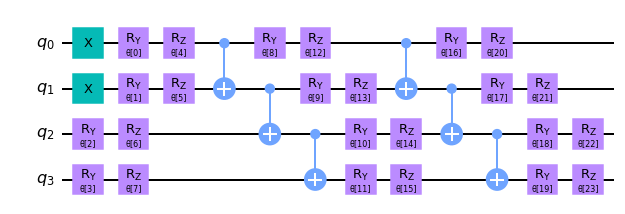

In [10]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=2 ) )
ansatz.draw(output='mpl')

In [11]:
prob2Exp =  probability2expected( coeff, label, Groups_bell_paris, Measurements_bell_paris )
len(prob2Exp)

9

In [12]:
qc = []
n_measure = []
for measure in Measurements_bell_paris :
    qc_temp, n_measure_temp = measure_circuit_factor( measure , num_qubits )
    qc.append( qc_temp.compose(ansatz,front=True) )
    n_measure.append( n_measure_temp )

In [13]:
def Objective( pars, qc, callback=None, backend=AerSimulator(method="statevector") ) :
    
    qc = [ qci.assign_parameters(pars) for qci in qc ]
    t_qc = transpile(qc, backend)
    qc_obj = assemble(t_qc, shots=NUM_SHOTS)
    counts = backend.run(qc_obj).result().get_counts()
     
    probabilities = [ post_process_results(counts[j], n_measure[j], NUM_SHOTS) for j in range(len(counts))]
    
    ExpectedValues = 0
    for j in range(len(probabilities)) :
        ExpectedValues += np.sum( prob2Exp[j]@probabilities[j] )
        
    if callback is not None :
        callback( ExpectedValues, pars )
        
    return ExpectedValues    

In [14]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var
fun1 = lambda pars : Objective( pars, qc, backend=backend_noise )
fun2 = lambda pars : objective_function(pars, coeff, label, Groups_tpb, Measurements_tpb, ansatz, backend_sim, NUM_SHOTS)

In [15]:
fun1(pars)

-0.549853196531925

In [16]:
fun2(pars)

-0.5519737983157067

In [17]:
Hamiltonian = qubit_op.to_matrix()
qc_state = ansatz.assign_parameters(pars)
qc_state.save_statevector()
state = backend_sim.run(qc_state).result().get_statevector()
np.vdot( state, Hamiltonian@state )

(-0.5519917902463968-1.9081958235744878e-17j)

In [18]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc   = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887061050307454


In [19]:
def callback( evals, params ):  
    display("{}, {}".format(len(evaluations),evals))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []

fun = lambda pars : Objective( pars, qc , callback, backend_noise )

optimizer = SPSA( maxiter=300, last_avg=25 )

In [20]:
results = optimizer.optimize( num_var, fun, initial_point=pars )

'650, -1.0212614159641566'

In [21]:
results

(array([-3.09463764e+00, -3.13942122e+00, -6.23020769e+00, -4.37156796e+00,
        -3.99897157e+00,  4.95774131e+00, -2.13027212e+00, -1.63040876e+00,
         6.17069499e+00, -9.73306733e-03,  3.01287834e+00, -9.89527228e+00,
        -3.89503566e+00,  1.32775793e+01,  8.15265400e+00, -7.74572228e+00,
         9.28942106e+00, -3.11977412e+00,  3.19458607e+00,  1.90363658e+00,
        -5.09198113e+00, -1.87434181e+00, -7.36195850e+00, -8.40735381e+00]),
 -1.0212614159641566,
 600)

In [22]:
len( evaluations )

651

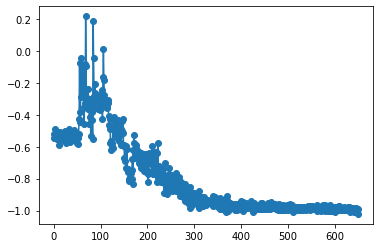

In [23]:
plt.plot(evaluations,'-o')

In [24]:
np.save( 'sim_noise_params_rep2', np.array(parameters) )
np.save( 'sim_noise_energy_rep2', np.array(evaluations) )